In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

In [2]:
df = pd.read_csv("./dataset/Rajan_MXene_data.csv")
df

,MXene,Eg(GW; eV),Eg(PBE; eV),phi(L)(eV),phi(U)(eV),d(angstrom),delta(d)(angstrom),V(angstrom^3-atom),APF,EV(eV),EC(eV),phi(N)(eV),a(angstrom),c,Hf(eV)
0,Y-Sc-C-Cl-OCN,3.3956,0.8756,2.1713,6.3336,2.4302,-0.0512,39.0152,0.3661,-5.6868,-4.8112,4.2524,3.5492,1,-11.2764
1,Y-Sc-C-Br-OCN,3.3659,0.8269,2.1340,6.3941,2.4424,-0.0634,39.7189,0.3667,-5.4308,-4.6039,4.2641,3.5791,1,-10.6495
2,Y-Sc-C-NCO-Cl,3.3072,0.9249,3.3325,4.5681,2.4290,-0.0500,39.0158,0.3661,-4.0290,-3.1041,3.9504,3.5509,1,-12.6013
3,Y-Sc-C-NCS-H,3.2661,0.9253,2.9483,3.2084,2.4139,-0.0349,38.2206,0.3786,-3.2805,-2.3552,3.0783,3.5155,1,-9.9570
4,Y-Sc-C-NCS-Cl,3.2553,0.8181,3.0055,4.3419,2.4407,-0.0617,39.6260,0.3724,-3.1205,-2.3024,3.6737,3.5785,1,-10.5544
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,Y-Sc-C-F-OH,1.8565,0.9421,0.6179,3.7123,2.3915,-0.0125,42.9717,0.3179,-2.4807,-1.5386,2.1651,3.4510,1,-13.2859
66,Sc-Y-C-Br-OH,1.8312,0.8316,0.4785,4.6437,2.4349,-0.0559,45.8995,0.3113,-2.5465,-1.7149,2.5612,3.5643,1,-10.5032
67,Sc-Y-C-Cl-OH,1.7317,0.8981,0.4122,4.7798,2.4223,-0.0434,54.0109,0.3113,-2.7664,-1.8683,2.5960,3.5318,1,-11.0999
68,Sc-Sc-C-Br-OH,1.6075,0.7363,-0.7587,4.1474,2.3315,0.2134,50.3116,0.2734,-3.1444,-2.4081,1.6943,3.4202,1,-10.6379


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# le.fit(df['MXene'])
df = df.drop(['MXene'], axis=1)



In [4]:
# select the features
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.ensemble import RandomForestRegressor

X = df.drop(['Eg(GW; eV)'], axis=1)
y = df['Eg(GW; eV)']
feature_selector = SelectKBest(k=8)
feature_selector.fit(X, y)
selected_features = X.columns[feature_selector.get_support()]
selected_features

Index(['Eg(PBE; eV)', 'phi(L)(eV)', 'delta(d)(angstrom)', 'APF', 'EV(eV)',
       'EC(eV)', 'phi(N)(eV)', 'Hf(eV)'],
      dtype='object')

In [5]:
df = df[selected_features.tolist() + ['Eg(GW; eV)']]

In [6]:
from hyperimpute.plugins.imputers import Imputers, ImputerPlugin
from Impute import fill_with_et

imputers = Imputers()


class EtImputer(ImputerPlugin):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._model = fill_with_et

    @staticmethod
    def name():
        return "et"

    @staticmethod
    def hyperparameter_space():
        return []

    def _fit(self, *args, **kwargs):
        return self

    def _transform(self, df):
        # 按照缺失值的比例进行排序
        miss_rate = df.isnull().sum() / df.shape[0]
        cols = miss_rate.sort_values().index.tolist()
        cols = [col for col in cols if miss_rate[col] > 0]
        for col in cols:
            df_col_filled = self._model(df, col)
            df[col] = df_col_filled[col]
        return df


imputers.add("et", EtImputer)

hyper = imputers.get("hyperimpute", n_inner_iter=1)
et = imputers.get("et")
missforest = imputers.get("missforest", max_iter=1)
gain = imputers.get("gain", n_epochs=10)
sinkhorn = imputers.get("sinkhorn", n_epochs=10)
mean = imputers.get("mean")

D:\software\miniconda\Lib\site-packages\pydantic\_internal\_fields.py:149: UserWarning: Field "model_name" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [7]:
target_col = "Eg(GW; eV)"

Hyperimpute score:  0.15947212857142862
Missforest score:  0.1423668571428572
ET score:  0.14284957142857097
Original score:  0.1482124571428569
Gain score:  0.13874057142857124
Sinkhorn score:  0.13627414285714276
Mean score:  0.16340449999999904
Hyperimpute score:  0.2795192142857144
Missforest score:  0.27473785714285776
ET score:  0.27942835714285735
Original score:  0.3045320714285718
Gain score:  0.298952785714286
Sinkhorn score:  0.28528057142857194
Mean score:  0.30623864285714353
Hyperimpute score:  0.19460592857142853
Missforest score:  0.18834707142857157
ET score:  0.21938807142857145
Original score:  0.1864942857142857
Gain score:  0.21479021428571451
Sinkhorn score:  0.19068428571428578
Mean score:  0.18249699999999985
Hyperimpute score:  0.2132085714285711
Missforest score:  0.19991035714285685
ET score:  0.13987889999999967
Original score:  0.14880348571428556
Gain score:  0.18340185714285678
Sinkhorn score:  0.1966473571428564
Mean score:  0.18746885714285697
Hyperimpu

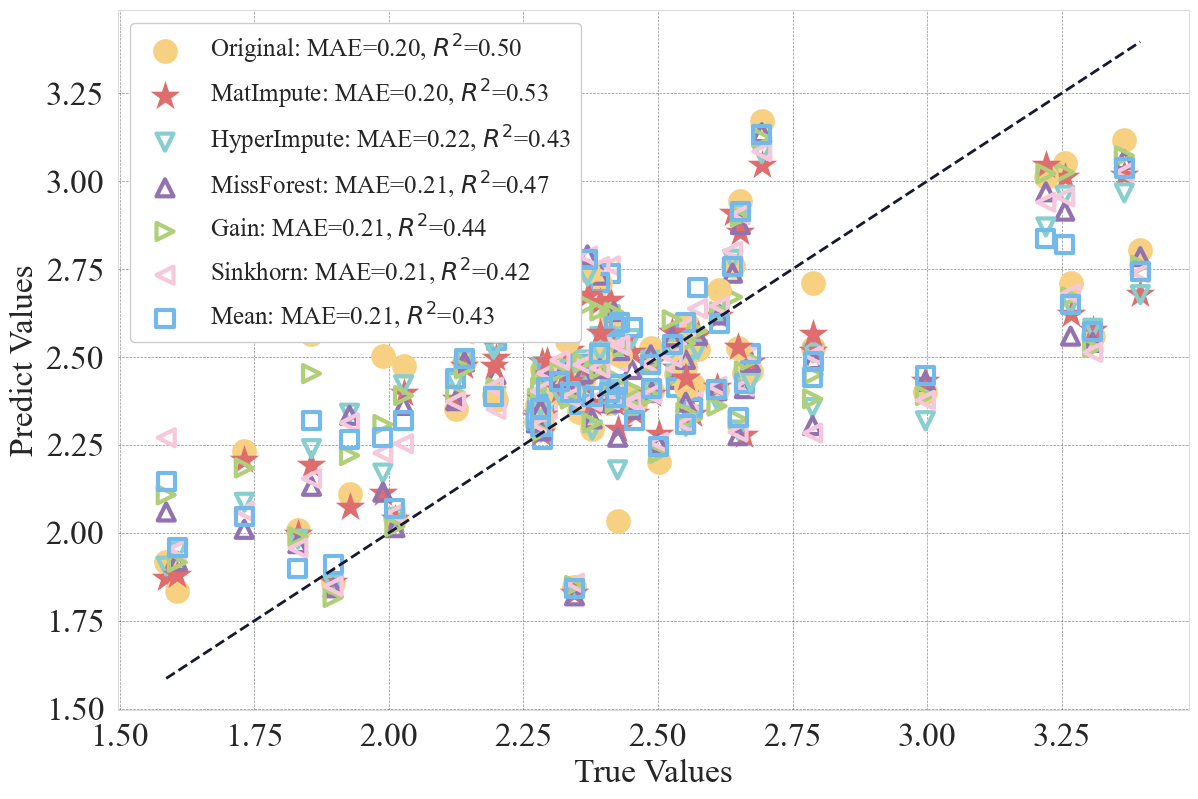

In [11]:
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from hyperimpute.plugins.utils.simulate import simulate_nan
from sklearn.metrics import r2_score, mean_absolute_error as MAE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import warnings

warnings.filterwarnings("ignore")

sns.set_theme(style="whitegrid")
plt.style.use(['nature', 'grid'])
# set font as times new roman
plt.rcParams["font.family"] = "Times New Roman"
plt.figure(figsize=(12, 8))

X = df.drop([target_col], axis=1)
y = df[target_col]

kf = KFold(n_splits=5, shuffle=True, random_state=0)
np.random.seed(0)

scores_et = []
r2_scores_et = []

scores_hyper = []
r2_scores_hyper = []

scores_missforest = []
r2_scores_missforest = []

scores_ori = []
r2_scores_ori = []

scores_gain = []
r2_scores_gain = []

scores_sinkhorn = []
r2_scores_sinkhorn = []

scores_mean = []
r2_scores_mean = []

for i, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    df_train = pd.concat([X_train, y_train], axis=1)
    df_test = pd.concat([X_test, y_test], axis=1)
    # reset the index
    df_train = df_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    X_train = df_train.drop([target_col], axis=1)
    y_train = df_train[target_col]
    X_test = df_test.drop([target_col], axis=1)
    y_test = df_test[target_col]
    cols = X_train.columns

    X_train = X_train.to_numpy()
    ret = simulate_nan(X_train, 0.1, mecha="MCAR")
    X_train_null = ret['X_incomp']
    mask = ret['mask']
    X_train_null = pd.DataFrame(X_train_null, columns=cols)

    X_imputed_hyper = hyper.fit_transform(X_train_null.copy())
    X_imputed_missforest = missforest.fit_transform(X_train_null.copy())
    X_imputed_et = et.fit_transform(X_train_null.copy())
    X_imputed_gain = gain.fit_transform(X_train_null.copy())
    X_imputed_sinkhorn = sinkhorn.fit_transform(X_train_null.copy())
    X_imputed_mean = mean.fit_transform(X_train_null.copy())

    rf = RandomForestRegressor()
    rf.fit(X_imputed_hyper, y_train)
    y_pred_hyper = rf.predict(X_test)
    hyper_score = MAE(y_test, y_pred_hyper)
    r2_hyper = r2_score(y_test, y_pred_hyper)
    print("Hyperimpute score: ", hyper_score)

    rf = RandomForestRegressor()
    rf.fit(X_imputed_missforest, y_train)
    y_pred_missforest = rf.predict(X_test)
    missforest_score = MAE(y_test, y_pred_missforest)
    r2_missforest = r2_score(y_test, y_pred_missforest)
    print("Missforest score: ", missforest_score)

    rf = RandomForestRegressor()
    rf.fit(X_imputed_et, y_train)
    y_pred_et = rf.predict(X_test)
    et_score = MAE(y_test, y_pred_et)
    r2_et = r2_score(y_test, y_pred_et)
    print("ET score: ", et_score)

    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    ori_score = MAE(y_test, y_pred)
    r2_ori = r2_score(y_test, y_pred)
    print("Original score: ", ori_score)

    rf = RandomForestRegressor()
    rf.fit(X_imputed_gain, y_train)
    y_pred_gain = rf.predict(X_test)
    gain_score = MAE(y_test, y_pred_gain)
    r2_gain = r2_score(y_test, y_pred_gain)
    print("Gain score: ", gain_score)

    rf = RandomForestRegressor()
    rf.fit(X_imputed_sinkhorn, y_train)
    y_pred_sinkhorn = rf.predict(X_test)
    sinkhorn_score = MAE(y_test, y_pred_sinkhorn)
    r2_sinkhorn = r2_score(y_test, y_pred_sinkhorn)
    print("Sinkhorn score: ", sinkhorn_score)

    rf = RandomForestRegressor()
    rf.fit(X_imputed_mean, y_train)
    y_pred_mean = rf.predict(X_test)
    mean_score = MAE(y_test, y_pred_mean)
    r2_mean = r2_score(y_test, y_pred_mean)
    print("Mean score: ", mean_score)

    scores_et.append(et_score)
    scores_hyper.append(hyper_score)
    scores_missforest.append(missforest_score)
    scores_gain.append(gain_score)
    scores_sinkhorn.append(sinkhorn_score)
    scores_mean.append(mean_score)
    scores_ori.append(ori_score)

    r2_scores_et.append(r2_et)
    r2_scores_hyper.append(r2_hyper)
    r2_scores_missforest.append(r2_missforest)
    r2_scores_gain.append(r2_gain)
    r2_scores_sinkhorn.append(r2_sinkhorn)
    r2_scores_mean.append(r2_mean)
    r2_scores_ori.append(r2_ori)

    # plot
    sns.scatterplot(x=y_test, y=y_pred, s=250, marker='o', linewidths=2, facecolors='#F8D082',
                    edgecolors='#F8D082')
    sns.scatterplot(x=y_test, y=y_pred_et, marker='*', s=500, linewidths=0,
                    color='#E06D6D')
    sns.scatterplot(x=y_test, y=y_pred_hyper, marker='v', s=150,
                    linewidths=3, facecolors='none', edgecolors='#89CECE')
    sns.scatterplot(x=y_test, y=y_pred_missforest, marker='^', s=150,
                    linewidths=3, facecolors='none', edgecolors='#9372B2')
    sns.scatterplot(x=y_test, y=y_pred_gain, marker='>', s=150,
                    linewidths=3, facecolors='none', edgecolors='#AFCF78')
    sns.scatterplot(x=y_test, y=y_pred_sinkhorn, marker='<', s=150,
                    linewidths=3, facecolors='none', edgecolors='#F7C8DB')
    sns.scatterplot(x=y_test, y=y_pred_mean, marker='s', s=150,
                    linewidths=3, facecolors='none', edgecolors='#73BAEB')
    print("=====================================")

plt.legend(['Original: MAE={:.2f}, $R^2$={:.2f}'.format(np.mean(scores_ori), np.mean(r2_scores_ori)),
            'MatImpute: MAE={:.2f}, $R^2$={:.2f}'.format(np.mean(scores_et), np.mean(r2_scores_et)),
            'HyperImpute: MAE={:.2f}, $R^2$={:.2f}'.format(np.mean(scores_hyper), np.mean(r2_scores_hyper)),
            'MissForest: MAE={:.2f}, $R^2$={:.2f}'.format(np.mean(scores_missforest), np.mean(r2_scores_missforest)),
            'Gain: MAE={:.2f}, $R^2$={:.2f}'.format(np.mean(scores_gain), np.mean(r2_scores_gain)),
            'Sinkhorn: MAE={:.2f}, $R^2$={:.2f}'.format(np.mean(scores_sinkhorn), np.mean(r2_scores_sinkhorn)),
            'Mean: MAE={:.2f}, $R^2$={:.2f}'.format(np.mean(scores_mean), np.mean(r2_scores_mean))], loc='upper left',
           fontsize=18)

plt.plot([np.min(y), np.max(y)], [np.min(y), np.max(y)], 'k--', lw=2, color='#161A30')
plt.xlabel('True Values', fontsize=24)
plt.ylabel('Predict Values', fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.tight_layout()
plt.savefig('pipeline-regression-Rajan.png', dpi=300)


In [12]:
print("Hyperimpute score:{:.2f}±{:.2f}".format(np.mean(scores_hyper), np.std(scores_hyper)))
print("Missforest score:{:.2f}±{:.2f}".format(np.mean(scores_missforest), np.std(scores_missforest)))
print("ET score:{:.2f}±{:.2f}".format(np.mean(scores_et), np.std(scores_et)))
print("Original score:{:.2f}±{:.2f}".format(np.mean(scores_ori), np.std(scores_ori)))
print("Gain score:{:.2f}±{:.2f}".format(np.mean(scores_gain), np.std(scores_gain)))
print("Sinkhorn score:{:.2f}±{:.2f}".format(np.mean(scores_sinkhorn), np.std(scores_sinkhorn)))
print("Mean score:{:.2f}±{:.2f}".format(np.mean(scores_mean), np.std(scores_mean)))

Hyperimpute score:0.22±0.04
Missforest score:0.21±0.04
ET score:0.20±0.05
Original score:0.20±0.06
Gain score:0.21±0.05
Sinkhorn score:0.21±0.05
Mean score:0.21±0.05


In [13]:
print("Hyperimpute r2:{:.2f}±{:.2f}".format(np.mean(r2_scores_hyper), np.std(r2_scores_hyper)))
print("Missforest r2:{:.2f}±{:.2f}".format(np.mean(r2_scores_missforest), np.std(r2_scores_missforest)))
print("ET r2:{:.2f}±{:.2f}".format(np.mean(r2_scores_et), np.std(r2_scores_et)))
print("Original r2:{:.2f}±{:.2f}".format(np.mean(r2_scores_ori), np.std(r2_scores_ori)))
print("Gain r2:{:.2f}±{:.2f}".format(np.mean(r2_scores_gain), np.std(r2_scores_gain)))
print("Sinkhorn r2:{:.2f}±{:.2f}".format(np.mean(r2_scores_sinkhorn), np.std(r2_scores_sinkhorn)))
print("Mean r2:{:.2f}±{:.2f}".format(np.mean(r2_scores_mean), np.std(r2_scores_mean)))

Hyperimpute r2:0.43±0.06
Missforest r2:0.47±0.02
ET r2:0.53±0.14
Original r2:0.50±0.12
Gain r2:0.44±0.08
Sinkhorn r2:0.42±0.08
Mean r2:0.43±0.10
